In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from math import log
from math import exp
from scipy.stats import boxcox 
from pandas import DataFrame
from pandas import Grouper
from pandas import Series
from pandas import concat
from pandas.plotting import lag_plot
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from matplotlib import pyplot
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.gofplots import qqplot
import warnings

In [2]:
df = pd.read_csv('data/zillow_data.csv')
df_income = pd.read_csv('data/zip_codes_2019_median_inc.csv')

In [3]:
df.columns = df.columns.str.strip().str.lower()
df_income.columns = df_income.columns.str.strip().str.lower()

In [4]:
df.rename(columns={'regionname': 'zipcode', 'countyname':'county'},inplace=True)
df_income.rename(columns={
    'zip code':'zipcode', 'population (2019)': 'population',
    'median family income (2019)': 'median_family_income'},
                 inplace=True)

In [5]:
df = df[df['state']=='TX']
df_income['state'] = df_income['preferred name'].str.slice(-2)
df_income = df_income[df_income['state']=='TX']
df_income = (df_income[df_income['type'] != 'PO box'])

In [6]:
#Calculate historical return on investment
df['ROI']= (df['2018-04']/df['1996-04'])-1
df['ROI']


#Calculate standard deviation of monthly values
df['std']=df.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)

#Calculate historical mean value
df['mean']=df.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)

#Calculate coefficient of variance
df['CV']=df['std']/df['mean']

#Show calculated values
df[['zipcode','std','mean','ROI','CV']].head()

#Descriptive statistics of coefficients of variance.
print(df.CV.describe())

#Define upper limit of CV according to risk profile.
upper_cv = df.CV.quantile(.6)
print(f'\nCV upper limit: {upper_cv}')

#Get the 5 zipcodes with highest ROIs within the firms risk profile.
zc_best5 = df[df['CV']<upper_cv].sort_values('ROI',axis=0,ascending=False)[:5]
print('\n Best 5 Zipcodes:')
zc_best5[['zipcode','ROI','CV']]

warnings.filterwarnings('ignore')

count    989.000000
mean       0.167433
std        0.041415
min        0.045182
25%        0.142279
50%        0.165783
75%        0.189448
max        0.361446
Name: CV, dtype: float64

CV upper limit: 0.17479440936725246

 Best 5 Zipcodes:


In [7]:
# RegionID is something from Zillow, don't need it and we don't need state any more.
df.drop(['regionid', 'sizerank', 'metro'], axis=1,inplace=True)

In [8]:
# we only want zipcode, pop, mfi, lat and long from 2019 income data
df_income = df_income[df_income.columns[np.r_[0,5,7,9:11]]]
df_income

,zipcode,population,median_family_income,latitude,longitude
31142,73301,NaN,NaN,NaN,NaN
31143,73344,NaN,NaN,NaN,NaN
31744,75001,"14,992","$79,551",32.959999,-96.838997
31745,75002,"71,253","$105,656",33.090000,-96.609001
31746,75006,"51,642","$72,325",32.962002,-96.899002
...,...,...,...,...,...
34257,79961,NaN,NaN,NaN,NaN
34258,79968,NaN,NaN,NaN,NaN
34259,79976,NaN,NaN,NaN,NaN
34260,79978,NaN,NaN,NaN,NaN


In [9]:
# fixing mfi and pop columns
df_income['median_family_income'] = df_income['median_family_income'].str.strip('$\n\t')
df_income['median_family_income'] = df_income['median_family_income'].str.replace(',','')
df_income = df_income[df_income['median_family_income'].notna()]
df_income['median_family_income'] = df_income['median_family_income'].astype(int)
df_income['population'] = df_income['population'].str.replace(',','')
df_income['population'] = df_income['population'].astype(int)

In [10]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['zipcode', 'city', 'state', 'county','ROI','std','mean','CV'], var_name='date')
    melted['date'] = pd.to_datetime(melted['date'], infer_datetime_format=True)
    melted['year'] = [d.year for d in melted.date]
    melted = melted.dropna(subset=['value'])
    return melted

In [11]:
df = melt_data(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255096 entries, 0 to 262084
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   zipcode  255096 non-null  int64         
 1   city     255096 non-null  object        
 2   state    255096 non-null  object        
 3   county   255096 non-null  object        
 4   ROI      250160 non-null  float64       
 5   std      255096 non-null  float64       
 6   mean     255096 non-null  float64       
 7   CV       255096 non-null  float64       
 8   date     255096 non-null  datetime64[ns]
 9   value    255096 non-null  float64       
 10  year     255096 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(3)
memory usage: 23.4+ MB


In [12]:
df.set_index(df['date'], inplace = True)
df.drop('date',axis=1, inplace=True)
df

,zipcode,city,state,county,ROI,std,mean,CV,value,year
date,,,,,,,,,,
1996-04-01,75070,McKinney,TX,Collin,0.365295,33537.101427,219655.849057,0.152680,235700.0,1996
1996-04-01,77494,Katy,TX,Harris,0.567966,37730.794353,262110.566038,0.143950,210400.0,1996
1996-04-01,79936,El Paso,TX,El Paso,0.571798,18167.079218,101875.471698,0.178326,77300.0,1996
1996-04-01,77084,Houston,TX,Harris,0.729474,17242.109812,121185.283019,0.142279,95000.0,1996
1996-04-01,77449,Katy,TX,Harris,0.846960,18603.288493,126530.188679,0.147026,95400.0,1996
...,...,...,...,...,...,...,...,...,...,...
2018-04-01,76941,Mertzon,TX,Irion,NaN,13734.029878,99318.367347,0.138283,121600.0,2018
2018-04-01,79313,Anton,TX,Hockley,NaN,5286.674724,54424.675325,0.097137,63300.0,2018
2018-04-01,79355,Plains,TX,Yoakum,NaN,12929.465872,78967.346939,0.163732,93500.0,2018


In [13]:
df_merged = df.reset_index().merge(df_income, how='left').set_index('date')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 255096 entries, 1996-04-01 to 2018-04-01
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   zipcode               255096 non-null  int64  
 1   city                  255096 non-null  object 
 2   state                 255096 non-null  object 
 3   county                255096 non-null  object 
 4   ROI                   250160 non-null  float64
 5   std                   255096 non-null  float64
 6   mean                  255096 non-null  float64
 7   CV                    255096 non-null  float64
 8   value                 255096 non-null  float64
 9   year                  255096 non-null  int64  
 10  population            252181 non-null  float64
 11  median_family_income  252181 non-null  float64
 12  latitude              252181 non-null  float64
 13  longitude             252181 non-null  float64
dtypes: float64(9), int64(2), object(3)
m

In [14]:
df_merged_for_later = df_merged

In [15]:
df_merged_upper_pop = df_merged['population'].quantile(.75)
df_filtered = df_merged[(df_merged['population'] > df_merged_upper_pop)]

In [16]:
# Select the first quantile
q1 = df_filtered['value'].quantile(.25)

# Select the third quantile
q3 = df_filtered['value'].quantile(.75)


# Create a filtered in between q1 & q3
filtered = df_filtered[(df_filtered['value']>=q1) 
             & (df_filtered['value']<=q3)]
df_filtered = pd.DataFrame(filtered)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31421 entries, 1996-04-01 to 2018-04-01
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zipcode               31421 non-null  int64  
 1   city                  31421 non-null  object 
 2   state                 31421 non-null  object 
 3   county                31421 non-null  object 
 4   ROI                   31421 non-null  float64
 5   std                   31421 non-null  float64
 6   mean                  31421 non-null  float64
 7   CV                    31421 non-null  float64
 8   value                 31421 non-null  float64
 9   year                  31421 non-null  int64  
 10  population            31421 non-null  float64
 11  median_family_income  31421 non-null  float64
 12  latitude              31421 non-null  float64
 13  longitude             31421 non-null  float64
dtypes: float64(9), int64(2), object(3)
memory usage: 3.6+

In [17]:
# group by date and aggregate on median value
df_filtered['median_house_price'] = df_filtered.groupby('date').aggregate({'value':'median'})
df_filtered['affordability'] = df_filtered['value'] - df_filtered['median_family_income']/.12

In [18]:
# create function to normalize data
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
df_filtered['affordability_score']  = normalize_data(df_filtered['affordability'])
df_filtered

,zipcode,city,state,county,ROI,std,mean,CV,value,year,population,median_family_income,latitude,longitude,median_house_price,affordability,affordability_score
date,,,,,,,,,,,,,,,,,
1996-04-01,78660,Pflugerville,TX,Travis,0.748020,24894.592870,168193.584906,0.148012,138900.0,1996,91300.0,99733.0,30.440001,-97.595001,124500.0,-692208.333333,0.409033
1996-04-01,77573,League City,TX,Galveston,0.848656,29647.359699,183261.509434,0.161776,141400.0,1996,88131.0,121943.0,29.504000,-95.086998,124500.0,-874791.666667,0.221835
1996-04-01,77584,Pearland,TX,Brazoria,0.851986,27064.756641,188628.301887,0.143482,138500.0,1996,90372.0,126143.0,29.545000,-95.350998,124500.0,-912691.666667,0.182977
1996-04-01,79912,El Paso,TX,El Paso,0.571429,26245.575483,154012.075472,0.170412,119700.0,1996,78267.0,77146.0,31.849001,-106.533997,124500.0,-523183.333333,0.582329
1996-04-01,78130,New Braunfels,TX,Comal,0.784504,23349.861603,153368.301887,0.152247,123900.0,1996,77400.0,76824.0,29.694000,-98.072998,124500.0,-516300.000000,0.589387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,78552,Harlingen,TX,Cameron,0.468835,9181.535729,85940.377358,0.106836,108400.0,2018,37948.0,52891.0,26.194000,-97.750999,144750.0,-332358.333333,0.777977
2018-04-01,77014,Houston,TX,Harris,0.619588,15782.797130,122692.452830,0.128637,157100.0,2018,37488.0,55613.0,29.981001,-95.463997,144750.0,-306341.666667,0.804651
2018-04-01,77506,Pasadena,TX,Harris,1.255187,12538.003841,69982.264151,0.179160,108700.0,2018,38765.0,46462.0,29.714001,-95.199997,144750.0,-278483.333333,0.833214


In [19]:
df_merged_for_later

,zipcode,city,state,county,ROI,std,mean,CV,value,year,population,median_family_income,latitude,longitude
date,,,,,,,,,,,,,,
1996-04-01,75070,McKinney,TX,Collin,0.365295,33537.101427,219655.849057,0.152680,235700.0,1996,104415.0,115530.0,33.172001,-96.695999
1996-04-01,77494,Katy,TX,Harris,0.567966,37730.794353,262110.566038,0.143950,210400.0,1996,118291.0,148843.0,29.740999,-95.830002
1996-04-01,79936,El Paso,TX,El Paso,0.571798,18167.079218,101875.471698,0.178326,77300.0,1996,111620.0,61016.0,31.777000,-106.296997
1996-04-01,77084,Houston,TX,Harris,0.729474,17242.109812,121185.283019,0.142279,95000.0,1996,107673.0,70460.0,29.827000,-95.660004
1996-04-01,77449,Katy,TX,Harris,0.846960,18603.288493,126530.188679,0.147026,95400.0,1996,128294.0,82716.0,29.837999,-95.734001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,76941,Mertzon,TX,Irion,NaN,13734.029878,99318.367347,0.138283,121600.0,2018,1455.0,64464.0,31.271999,-100.889000
2018-04-01,79313,Anton,TX,Hockley,NaN,5286.674724,54424.675325,0.097137,63300.0,2018,1528.0,49250.0,33.805000,-102.162003
2018-04-01,79355,Plains,TX,Yoakum,NaN,12929.465872,78967.346939,0.163732,93500.0,2018,1877.0,64563.0,33.181999,-102.876999


In [20]:
# filtering to the 20th percentile
top_20 = df_filtered['affordability_score'].quantile(.5)
top_20

0.5827053536337383

In [21]:
df_filtered_20 = df_filtered[(df_filtered['affordability_score'] < top_20)]

In [22]:
df_filtered_20.reset_index().isna().sum()

date                    0
zipcode                 0
city                    0
state                   0
county                  0
ROI                     0
std                     0
mean                    0
CV                      0
value                   0
year                    0
population              0
median_family_income    0
latitude                0
longitude               0
median_house_price      0
affordability           0
affordability_score     0
dtype: int64

In [23]:
df_filtered_2017 = df_filtered_20['2017-01-01':].dropna()

In [24]:
df_filtered_2017 = df_filtered_2017.reset_index()
df_filtered_top_roi = df_filtered_2017.loc[df_filtered_2017.groupby("zipcode")["ROI"].idxmax()].sort_values('ROI',axis=0,ascending=False)[:5]
df_filtered_top_roi.set_index('date',inplace=True)
df_filtered_top_roi

,zipcode,city,state,county,ROI,std,mean,CV,value,year,population,median_family_income,latitude,longitude,median_house_price,affordability,affordability_score
date,,,,,,,,,,,,,,,,,
2017-01-01,79423,Lubbock,TX,Lubbock,1.082037,21451.329003,105156.226415,0.203995,139000.0,2017,40303.0,82989.0,33.439999,-101.855003,145050.0,-552575.000000,0.552195
2017-01-01,77571,La Porte,TX,Harris,1.040936,20507.800452,116197.358491,0.176491,153100.0,2017,37427.0,85150.0,29.688000,-95.056999,145050.0,-556483.333333,0.548188
2017-01-01,76108,Fort Worth,TX,Tarrant,1.013480,17152.126989,106005.660377,0.161804,143500.0,2017,43169.0,80040.0,32.787998,-97.524002,145050.0,-523500.000000,0.582005
2017-01-01,75052,Grand Prairie,TX,Dallas,0.995040,19370.586349,134230.188679,0.144309,176200.0,2017,95495.0,85220.0,32.665001,-97.025002,145050.0,-533966.666667,0.571274
2017-01-01,75104,Cedar Hill,TX,Dallas,0.954222,18302.905606,129367.924528,0.141479,166100.0,2017,49171.0,83143.0,32.580002,-96.964996,145050.0,-526758.333333,0.578664


In [25]:
zipcodes = list(df_filtered_top_roi['zipcode'].values)

In [26]:
df_filtered_top_roi = df_filtered_top_roi[df_filtered_top_roi['zipcode'].isin(zipcodes)]

In [27]:
df_merged = df_merged[df_merged['zipcode'].isin(zipcodes)]

In [28]:
df_merged['zipcode'].value_counts()

77571    265
79423    265
75104    265
75052    265
76108    265
Name: zipcode, dtype: int64

In [29]:
df_prices = pd.DataFrame(df_merged[['zipcode','value']], index = df_merged.index)
df_prices.reset_index(inplace=True)

df_prices = df_prices.pivot('date', 'zipcode', 'value')
df_prices

zipcode,75052,75104,76108,77571,79423
date,,,,,
1996-04-01,100800.0,98300.0,81600.0,85500.0,70700.0
1996-05-01,100900.0,98500.0,81500.0,85600.0,70900.0
1996-06-01,101000.0,98700.0,81400.0,85800.0,71200.0
1996-07-01,101000.0,99000.0,81400.0,85900.0,71500.0
1996-08-01,101200.0,99200.0,81400.0,86000.0,71800.0
...,...,...,...,...,...
2017-12-01,194300.0,184400.0,158300.0,170300.0,147900.0
2018-01-01,195200.0,187000.0,160100.0,171800.0,148200.0
2018-02-01,196700.0,189100.0,161900.0,173100.0,148200.0


In [30]:
df_merged = df.reset_index().merge(df_income, how='left').set_index('date')

In [31]:
avg_prices = df.groupby('date').aggregate({'value':'median'})

In [32]:
df_merged_cv = df_merged[df_merged['zipcode'].isin(zipcodes)]

In [33]:
df_cv = pd.DataFrame(df_merged_cv[['zipcode','CV']], index = df_merged_cv.index)
df_cv.reset_index(inplace=True)

df_cv = df_cv.pivot('date', 'zipcode', 'CV')
df_cv

zipcode,75052,75104,76108,77571,79423
date,,,,,
1996-04-01,0.144309,0.141479,0.161804,0.176491,0.203995
1996-05-01,0.144309,0.141479,0.161804,0.176491,0.203995
1996-06-01,0.144309,0.141479,0.161804,0.176491,0.203995
1996-07-01,0.144309,0.141479,0.161804,0.176491,0.203995
1996-08-01,0.144309,0.141479,0.161804,0.176491,0.203995
...,...,...,...,...,...
2017-12-01,0.144309,0.141479,0.161804,0.176491,0.203995
2018-01-01,0.144309,0.141479,0.161804,0.176491,0.203995
2018-02-01,0.144309,0.141479,0.161804,0.176491,0.203995


In [34]:
df_merged_for_later_cv = df_merged_for_later.groupby('date').aggregate({'CV':'median'})

In [35]:
all_df = df_cv.merge(df_merged_for_later_cv, left_index=True, right_index=True)
all_df.rename(columns={'value': 'texas_cv'}, inplace=True)

In [36]:
df_merged_for_later['affordability'] = df_merged_for_later['value'] - df_merged_for_later['median_family_income']/.12
df_merged_for_later['affordability_score']  = normalize_data(df_merged_for_later['affordability'])
df_merged_for_later

,zipcode,city,state,county,ROI,std,mean,CV,value,year,population,median_family_income,latitude,longitude,affordability,affordability_score
date,,,,,,,,,,,,,,,,
1996-04-01,75070,McKinney,TX,Collin,0.365295,33537.101427,219655.849057,0.152680,235700.0,1996,104415.0,115530.0,33.172001,-96.695999,-7.270500e+05,0.515600
1996-04-01,77494,Katy,TX,Harris,0.567966,37730.794353,262110.566038,0.143950,210400.0,1996,118291.0,148843.0,29.740999,-95.830002,-1.029958e+06,0.349509
1996-04-01,79936,El Paso,TX,El Paso,0.571798,18167.079218,101875.471698,0.178326,77300.0,1996,111620.0,61016.0,31.777000,-106.296997,-4.311667e+05,0.677839
1996-04-01,77084,Houston,TX,Harris,0.729474,17242.109812,121185.283019,0.142279,95000.0,1996,107673.0,70460.0,29.827000,-95.660004,-4.921667e+05,0.644391
1996-04-01,77449,Katy,TX,Harris,0.846960,18603.288493,126530.188679,0.147026,95400.0,1996,128294.0,82716.0,29.837999,-95.734001,-5.939000e+05,0.588609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,76941,Mertzon,TX,Irion,NaN,13734.029878,99318.367347,0.138283,121600.0,2018,1455.0,64464.0,31.271999,-100.889000,-4.156000e+05,0.686374
2018-04-01,79313,Anton,TX,Hockley,NaN,5286.674724,54424.675325,0.097137,63300.0,2018,1528.0,49250.0,33.805000,-102.162003,-3.471167e+05,0.723925
2018-04-01,79355,Plains,TX,Yoakum,NaN,12929.465872,78967.346939,0.163732,93500.0,2018,1877.0,64563.0,33.181999,-102.876999,-4.445250e+05,0.670514


In [37]:
df_merged_for_later_5 = df_merged_for_later[df_merged_for_later['zipcode'].isin(zipcodes)]
df_merged_for_later_5

,zipcode,city,state,county,ROI,std,mean,CV,value,year,population,median_family_income,latitude,longitude,affordability,affordability_score
date,,,,,,,,,,,,,,,,
1996-04-01,75052,Grand Prairie,TX,Dallas,0.995040,19370.586349,134230.188679,0.144309,100800.0,1996,95495.0,85220.0,32.665001,-97.025002,-609366.666667,0.580128
1996-04-01,75104,Cedar Hill,TX,Dallas,0.954222,18302.905606,129367.924528,0.141479,98300.0,1996,49171.0,83143.0,32.580002,-96.964996,-594558.333333,0.588248
1996-04-01,76108,Fort Worth,TX,Tarrant,1.013480,17152.126989,106005.660377,0.161804,81600.0,1996,43169.0,80040.0,32.787998,-97.524002,-585400.000000,0.593269
1996-04-01,79423,Lubbock,TX,Lubbock,1.082037,21451.329003,105156.226415,0.203995,70700.0,1996,40303.0,82989.0,33.439999,-101.855003,-620875.000000,0.573818
1996-04-01,77571,La Porte,TX,Harris,1.040936,20507.800452,116197.358491,0.176491,85500.0,1996,37427.0,85150.0,29.688000,-95.056999,-624083.333333,0.572058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,75052,Grand Prairie,TX,Dallas,0.995040,19370.586349,134230.188679,0.144309,201100.0,2018,95495.0,85220.0,32.665001,-97.025002,-509066.666667,0.635125
2018-04-01,75104,Cedar Hill,TX,Dallas,0.954222,18302.905606,129367.924528,0.141479,192100.0,2018,49171.0,83143.0,32.580002,-96.964996,-500758.333333,0.639680
2018-04-01,76108,Fort Worth,TX,Tarrant,1.013480,17152.126989,106005.660377,0.161804,164300.0,2018,43169.0,80040.0,32.787998,-97.524002,-502700.000000,0.638615


In [38]:
df_tx_aff = df_merged_for_later.groupby('date').aggregate({'affordability_score':'median'})
df_tx_aff

,affordability_score
date,
1996-04-01,0.640439
1996-05-01,0.640439
1996-06-01,0.640393
1996-07-01,0.640366
1996-08-01,0.640384
...,...
2017-12-01,0.681476
2018-01-01,0.681629
2018-02-01,0.682077


In [39]:
df_aff = pd.DataFrame(df_merged_for_later_5[['zipcode','affordability_score']], index=df_merged_for_later_5.index)
df_aff.reset_index(inplace=True)

In [40]:
df_aff = df_aff.pivot('date', 'zipcode', 'affordability_score')
df_aff

zipcode,75052,75104,76108,77571,79423
date,,,,,
1996-04-01,0.580128,0.588248,0.593269,0.572058,0.573818
1996-05-01,0.580183,0.588357,0.593215,0.572113,0.573927
1996-06-01,0.580238,0.588467,0.593160,0.572223,0.574092
1996-07-01,0.580238,0.588631,0.593160,0.572278,0.574256
1996-08-01,0.580347,0.588741,0.593160,0.572333,0.574421
...,...,...,...,...,...
2017-12-01,0.631396,0.635458,0.635326,0.618556,0.616148
2018-01-01,0.631889,0.636884,0.636313,0.619379,0.616313
2018-02-01,0.632712,0.638035,0.637300,0.620091,0.616313


In [41]:
df_tx_aff = df_merged_for_later.groupby('date').aggregate({'affordability_score':'median'})
df_tx_aff

,affordability_score
date,
1996-04-01,0.640439
1996-05-01,0.640439
1996-06-01,0.640393
1996-07-01,0.640366
1996-08-01,0.640384
...,...
2017-12-01,0.681476
2018-01-01,0.681629
2018-02-01,0.682077


In [42]:
aff_df = df_aff.merge(df_tx_aff, left_index=True, right_index=True)
aff_df.rename(columns={'affordability_score': 'Texas'}, inplace=True)

In [43]:
aff_df = aff_df[['Texas', 75052, 75104, 76108, 77571, 79423]]
aff_df

,Texas,75052,75104,76108,77571,79423
date,,,,,,
1996-04-01,0.640439,0.580128,0.588248,0.593269,0.572058,0.573818
1996-05-01,0.640439,0.580183,0.588357,0.593215,0.572113,0.573927
1996-06-01,0.640393,0.580238,0.588467,0.593160,0.572223,0.574092
1996-07-01,0.640366,0.580238,0.588631,0.593160,0.572278,0.574256
1996-08-01,0.640384,0.580347,0.588741,0.593160,0.572333,0.574421
...,...,...,...,...,...,...
2017-12-01,0.681476,0.631396,0.635458,0.635326,0.618556,0.616148
2018-01-01,0.681629,0.631889,0.636884,0.636313,0.619379,0.616313
2018-02-01,0.682077,0.632712,0.638035,0.637300,0.620091,0.616313


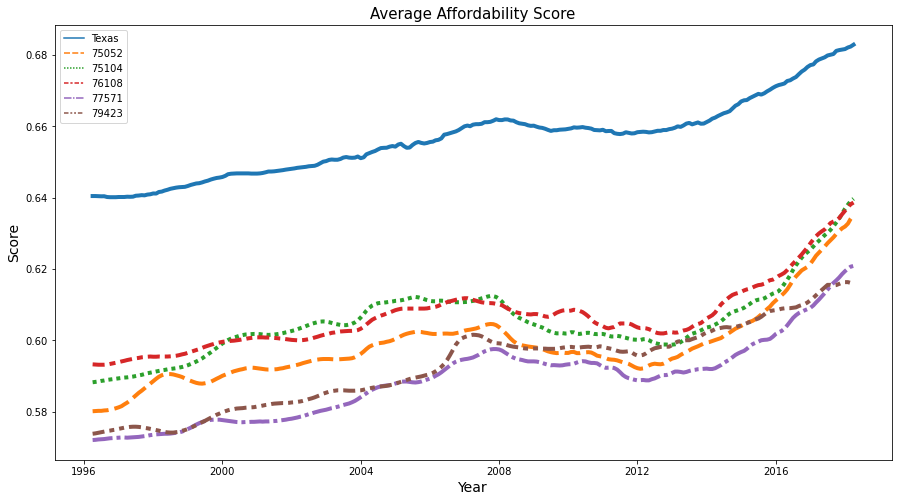

In [44]:
fig, ax = plt.subplots()
ax.set_title('Average Affordability Score', fontsize=15)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
sns.lineplot(data=aff_df, linewidth=4)
fig.set_size_inches(15, 8);
plt.savefig('images/avg_aff_score')

In [45]:
df_tx_roi = df_merged_for_later.groupby('date').aggregate({'ROI':'mean'})

In [46]:
df_roi = pd.DataFrame(df_merged_for_later_5[['zipcode','ROI']], index=df_merged_for_later_5.index)
df_roi.reset_index(inplace=True)

In [47]:
df_roi = df_roi.pivot('date', 'zipcode', 'ROI')

In [48]:
df_roi = df_roi.merge(df_tx_roi, left_index=True, right_index=True)
df_roi.rename(columns={'ROI': 'Average ROI'}, inplace=True)

In [49]:
df_roi = df_roi[[75052, 75104, 76108, 77571, 79423]]

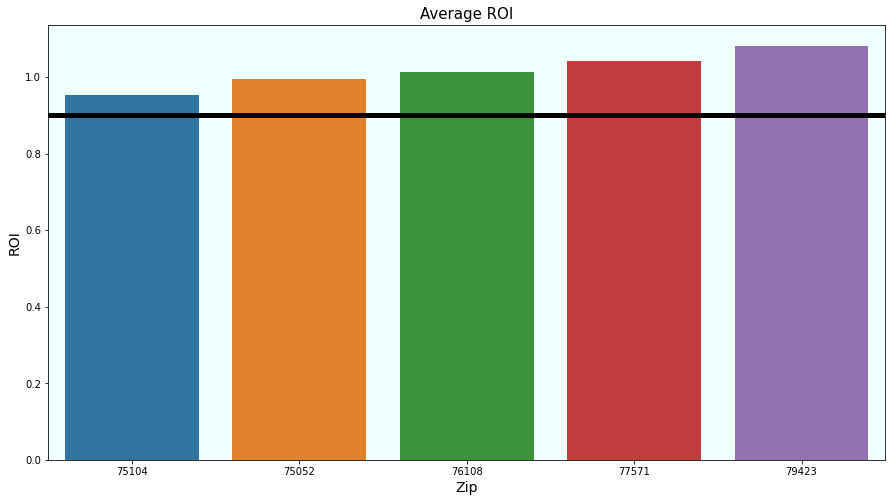

In [50]:
fig, ax = plt.subplots()
ax.set_title('Average ROI', fontsize=15)
ax.set_xlabel('Zip', fontsize=14)
ax.set_ylabel('ROI', fontsize=14)
sns.barplot(data=df_roi, linewidth=4,order=[75104, 75052,76108,77571,79423]).axhline(df_filtered['ROI'].mean(),linewidth=5,color='black')
fig.set_size_inches(15, 8)
ax.set_facecolor('azure');
plt.savefig('images/average_roi')

## Zip Training

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(train, order=(1, 0, 0))
sm = arima.fit()
print(sm.summary())

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax = SARIMAX(train, order=[1,0,0]).fit()
sarimax.summary()

In [ ]:
# Calculate the training root mean squared error (same syntax as a linear regression prediction)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(train, y_train_hat, squared=False)
rmse

In [ ]:
y_train_hat = sm.predict()
y_train_hat